# Reacher - REPORT + code

---

### 1. Load the necessary packages

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from ddpg_agent import Agent
%matplotlib inline


Next, we will start the environment! The next cell code should point to the path to the executbale environment created in Unity, examples for al platforms:

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacherx86_64"`


In [2]:
env = UnityEnvironment(file_name='Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments to be used used through Python contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of +0.1 is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of 33 variables corresponding to position, rotation, velocity, and angular velocities of the arm. Each action is a vector with four numbers, corresponding to torque applicable to two joints. Every entry in the action vector should be a number between -1 and 1.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]
States have length: 33


### 3. Instantiate a DDPG Agent

The next cell code instantiates the Agent class defined in the script **`ddpg_agent.py`**.

The Agent is reponsible of:
    - Simulating the environment's long-term rewards through Neural Netowrks forward passes
    - Accumulating experiences in a ReplayBuffer to train the networks on past situations of the environment
    - Implementing the Actor-Critic relationship as defined below to ensure a compromise between value & policy learnings

In [5]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=1616)

### 4. Define the Deep Deterministic Policy Gradient algorithm to learn a policy on the environment

The DDPG algorithm pseudo-code:

![alt text](https://cdn-images-1.medium.com/max/1600/1*qV8STzz6mEYIKjOXyibtrQ.png)

The main improvements used with respect to the Bipedal example are:

BatchNorm:

![alt text](https://kratzert.github.io/images/bn_backpass/bn_algorithm.PNG)

We sum the rewards for each episode to measure learning. The environment is said to be solved when the average episodic reward through 100 consecutive episodes is >= 30.0

In [6]:
def ddpg(n_episodes=1000, max_t=10000, print_every=100):
    """DDPG Algorithm.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        print_every (int): frequency of printing information throughout iteration """
    # Empty lists to append individual scores
    scores = []
    scores_deque = deque(maxlen=print_every)
    # For each episode:
    for i_episode in range(1, n_episodes+1):
        # Restart the environment & the agent
        env_info = env.reset(train_mode=True)[brain_name]
        agent.reset()
        # Get the initial state
        state = env_info.vector_observations[0]            
        score = 0
        # For every timestep in the episode:
        for t in range(max_t):
            # Choose an action based on the learned policy
            action = agent.act(state)          
            # Get new state after chosen action
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            # Get reward from specified action
            reward = env_info.rewards[0]      
            # Check if the episode is done
            done = env_info.local_done[0]
            # Learning!
            agent.step(state, action, reward, next_state, done) 
            # Accumulate score & set up next state
            score += reward                                
            state = next_state                             
            if done:                                       
                break
        # Accumulate scores to check whether env. is solved or not
        scores_deque.append(score)       
        scores.append(score)             

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        
        if np.mean(scores_deque)>=30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
            
    return scores

Episode 100	Average Score: 4.10
Episode 200	Average Score: 19.91
Episode 247	Average Score: 30.11
Environment solved in 247 episodes!	Average Score: 30.11


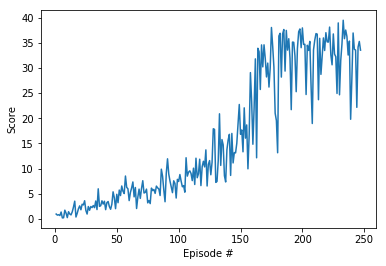

In [7]:
scores = ddpg(n_episodes = 1500)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [8]:
env.close()

Now let's run it in a test environment to check if it actually learned anything:

In [ ]:
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))
# Change with real path to the Reacher with visualization enbaled to see it in action!
env = UnityEnvironment(file_name='Reacher_Linux/Reacher.x86_64')
state = env.reset()
for t in range(200):
    action = agent.act(state, add_noise=False)
    env.render()
    state, reward, done, _ = env.step(action)
    if done:
        break 

env.close()

### 5. Future work

Future improvements of the Agent could include:
- PPO to solve the multi agent case
- Improve speed to achieve 30 acc. reward
- prioritized experience replay
- using raw pixels as input instead of state vector